In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a de

In [2]:
import nltk.corpus
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Dataset

In [3]:
df = pd.read_excel('text_all.xlsx') #textA
df

letter  \
0                    Biden $15 million next week alone   
1                       Biden $90 million worth of ads   
2          Biden Look at the states we're investing in   
3             Biden We must protect the postal service   
4                            Biden Caring Economy Town   
..                                                 ...   
806  sanders Your $5 contribution will support thes...   
807  sanders Your support for my amendment will sen...   
808  sanders Your response is requested to send a p...   
809  sanders Your participation in our Day of Actio...   
810  sanders Your $10 contribution split between th...   

                                                  text  
0    We're running these ads on TV, online, over th...  
1    Donald Trump just reserved more than $90 milli...  
2       making major investments to beat Donald Trump:  
3    We must protect the postal service  Donald Tru...  
4    Join Team Joe for a virtual town hall to discu...  
..                                                 ...  
806  Friends -\nAs people across the country contin...  
807  Friends - \nWe're writing to ask if you can sp...  
808  Friends -\nAs you well know, real change does ...  
809  Friends -\nWe are in the midst of the worst se...  
810  Friends -\nAt this unprecedented moment in Ame...  

[811 rows x 2 columns]

## Data preprocesing 

In [4]:
data = df.text.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("-'", "", sent) for sent in data]
data = [re.sub("--'", "", sent) for sent in data]
pprint(data[:1])

['Were running these ads on TV, online, over the radio, and more in '
 'battleground states that Donald Trump won in 2016 -- including Arizona, '
 'Florida, Michigan, North Carolina, Pennsylvania, and Wisconsin']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['were', 'running', 'these', 'ads', 'on', 'tv', 'online', 'over', 'the', 'radio', 'and', 'more', 'in', 'battleground', 'states', 'that', 'donald', 'trump', 'won', 'in', 'including', 'arizona', 'florida', 'michigan', 'north', 'carolina', 'pennsylvania', 'and', 'wisconsin']]


In [6]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['were', 'running', 'these', 'ads', 'on', 'tv', 'online', 'over', 'the', 'radio', 'and', 'more', 'in', 'battleground_states', 'that', 'donald', 'trump', 'won', 'in', 'including', 'arizona', 'florida', 'michigan', 'north_carolina', 'pennsylvania', 'and', 'wisconsin']


In [7]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['run', 'ad', 'tv', 'online', 'radio', 'battleground', 'state', 'donald', 'trump', 'include', 'arizona', 'florida', 'michigan', 'pennsylvania', 'wisconsin']]


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [9]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ad', 1),
  ('arizona', 1),
  ('battleground', 1),
  ('donald', 1),
  ('florida', 1),
  ('include', 1),
  ('michigan', 1),
  ('online', 1),
  ('pennsylvania', 1),
  ('radio', 1),
  ('run', 1),
  ('state', 1),
  ('trump', 1),
  ('tv', 1),
  ('wisconsin', 1)]]

## Coherence Score

In [11]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [13]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 100
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = 0.3
# Beta parameter
beta = 0.3
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=194)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            
                    # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=alpha, b=beta)
                    # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(alpha)
            model_results['Beta'].append(beta)
            model_results['Coherence'].append(cv)
                    
            pbar.update(1)


100%|██████████████████████████████████████████████████████████████████████████████| 194/194 [2:40:07<00:00, 61.08s/it]

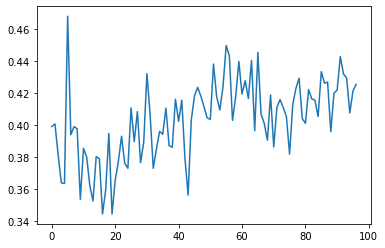

In [14]:
df1=pd.DataFrame(model_results)
df1=df1[df1["Validation_Set"] == '75% Corpus']
plt.plot(df1["Coherence"])

In [15]:
df1.head(15)

Validation_Set  Topics  Alpha  Beta  Coherence
0      75% Corpus       3    0.3   0.3   0.399077
1      75% Corpus       4    0.3   0.3   0.400750
2      75% Corpus       5    0.3   0.3   0.381500
3      75% Corpus       6    0.3   0.3   0.364055
4      75% Corpus       7    0.3   0.3   0.363600
5      75% Corpus       8    0.3   0.3   0.467929
6      75% Corpus       9    0.3   0.3   0.393999
7      75% Corpus      10    0.3   0.3   0.399093
8      75% Corpus      11    0.3   0.3   0.397721
9      75% Corpus      12    0.3   0.3   0.353791
10     75% Corpus      13    0.3   0.3   0.385573
11     75% Corpus      14    0.3   0.3   0.380120
12     75% Corpus      15    0.3   0.3   0.362162
13     75% Corpus      16    0.3   0.3   0.352707
14     75% Corpus      17    0.3   0.3   0.380383

## Vizualize Coherence Score

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
import tarfile
from urllib.request import urlopen

import pylab
plt.style.use('ggplot')

In [17]:
def add_titlebox1(ax, text):
    ax.text(.83, .87, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=15)
    return ax

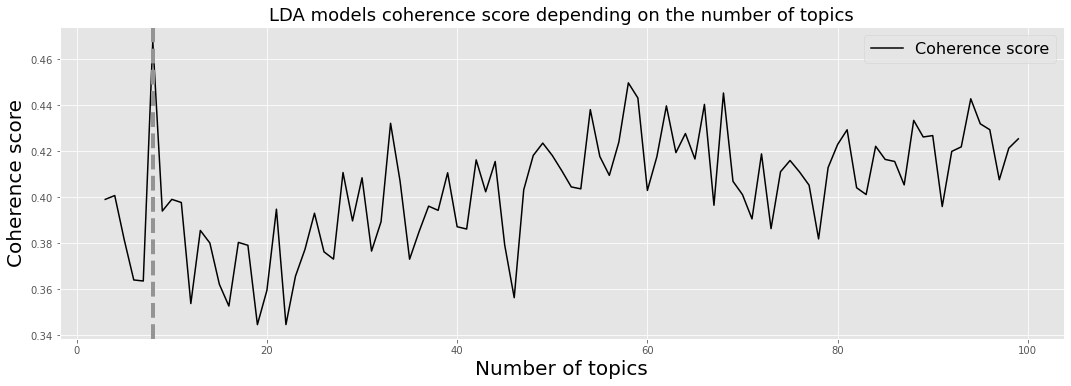

In [26]:
gridsize = (4, 2)

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)

ax1.set_title(
    'LDA models coherence score depending on the number of topics',
    fontsize=18
)

ax1.plot(df1['Topics'], df1['Coherence'], color='#000000', label = 'Coherence score')

ax1.axvline(linewidth=4, color='#949494', linestyle = '--', x=8, ymin=0, ymax=1)

ax1.set_xlabel('Number of topics', fontsize=20, color='#000000')
ax1.set_ylabel('Coherence score', fontsize=20, color='#000000')

plt.legend(fontsize=16)

## Run LDA model

In [27]:
import gensim
import pyLDAvis.gensim_models

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, #20 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model.print_topics()

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.069487531700647

Coherence Score:  0.45252833893840105


In [29]:
topicData = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds') 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')   
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.100425  0.340970       1        1  40.677831
0      0.106018  0.307600       2        1  25.751110
7      0.297739 -0.168543       3        1  13.700950
1      0.335511  0.112829       4        1   9.452845
3      0.036328 -0.386070       5        1   8.852415
2     -0.356488 -0.026046       6        1   1.292638
4     -0.189560 -0.151970       7        1   0.209155
6     -0.129123 -0.028770       8        1   0.063057, topic_info=             Term         Freq        Total Category  logprob  loglift
2030  progressive   308.000000   308.000000  Default  30.0000  30.0000
20            joe   486.000000   486.000000  Default  29.0000  29.0000
12          trump  1232.000000  1232.000000  Default  28.0000  28.0000
15          biden   460.000000   460.000000  Default  27.0000  27.0000
875     candidate   253.000000   253.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1804    caregiver     0.009706     0.811282   Topic8  -8.4246   2.9430
2946          nbc     0.009698     2.018350   Topic8  -8.4254   2.0308
2771    beautiful     0.009645     1.353100   Topic8  -8.4309   2.4252
80        virtual     0.009623     7.919839   Topic8  -8.4332   0.6559
1750          son     0.009614     2.600503   Topic8  -8.4341   1.7687

[433 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4162      6  0.853569    abortion
2048      1  0.990809  absolutely
509       1  0.018910         act
509       3  0.340379         act
509       4  0.009455         act
...     ...       ...         ...
3234      3  0.985276  xenophobia
257       1  0.697503        year
257       2  0.265852        year
257       3  0.037162        year
780       4  0.978035       young

[559 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 8, 2, 4, 3, 5, 7])

## Application of the LDA model to the corpus of texts

In [30]:
lda_model.save('lda.model')

In [31]:
lda_model.print_topics(20,num_words=15)[:10] #сколько топиков

[(0,
  '0.035*"trump" + 0.027*"joe" + 0.025*"biden" + 0.021*"donald" + 0.016*"defeat" + 0.015*"president" + 0.013*"go" + 0.012*"percent" + 0.011*"know" + 0.011*"campaign" + 0.010*"house" + 0.010*"say" + 0.009*"get" + 0.009*"elect" + 0.009*"team"'),
 (1,
  '0.046*"progressive" + 0.021*"congress" + 0.019*"movement" + 0.018*"elect" + 0.017*"campaign" + 0.015*"fight" + 0.014*"work" + 0.013*"bernie" + 0.013*"people" + 0.013*"important" + 0.011*"medicare" + 0.011*"pass" + 0.011*"lead" + 0.011*"contribution" + 0.011*"stand"'),
 (2,
  '0.090*"supreme_court" + 0.029*"upcoming" + 0.027*"justice" + 0.027*"tremendous" + 0.018*"discrimination" + 0.018*"barrett" + 0.018*"amy_coney" + 0.017*"nominate" + 0.014*"hearing" + 0.013*"winner" + 0.013*"confirm" + 0.013*"impeach" + 0.009*"confirmation" + 0.009*"pose" + 0.009*"constitution"'),
 (3,
  '0.019*"pandemic" + 0.016*"american" + 0.015*"crisis" + 0.015*"provide" + 0.015*"job" + 0.012*"million" + 0.012*"federal" + 0.011*"budget" + 0.011*"people" + 0.01

In [32]:
lda_model.print_topics()
count = 1
for line in data: # where each line in the document is its own sentence for simplicity
    print('\nSentence: ', line)
    line = line.split()
    line_bow = id2word.doc2bow(line)
    doc_lda = lda_model[line_bow]
    #print(doc_lda)
    count += 1
    print(doc_lda)


Sentence:  Were running these ads on TV, online, over the radio, and more in battleground states that Donald Trump won in 2016 -- including Arizona, Florida, Michigan, North Carolina, Pennsylvania, and Wisconsin
([(0, 0.6036592), (1, 0.03746513), (2, 0.012798468), (3, 0.029644387), (5, 0.24768588), (7, 0.061433617)], [(2, [0]), (2174, [0])], [(2, [(0, 0.9998839)]), (2174, [(0, 0.9998899)])])

Sentence:  Donald Trump just reserved more than $90 million worth of ads in key battleground states for this fall. That’s huge. everything it can this fall to secure the votes necessary to elect Joe Biden and defeat Donald Trump.
([(0, 0.495202), (1, 0.014315106), (3, 0.011338414), (5, 0.44752753), (7, 0.023958867)], [(2, [0]), (16, [0]), (17, [0]), (18, [0]), (22, [5]), (24, [5]), (26, [5]), (134, [5]), (678, [0])], [(2, [(0, 0.99986196)]), (16, [(0, 0.999984)]), (17, [(0, 0.9988047)]), (18, [(0, 0.99960655)]), (22, [(5, 0.9991229)]), (24, [(5, 0.9998004)]), (26, [(5, 0.99863297)]), (134, [(5, 0

In [34]:
def large(arr): 
    max_ = arr[0]
    for ele in arr:
        if ele > max_:
           max_ = ele
    return max_ 

In [35]:
a = []
c = []
lda_model.print_topics()
count = 1
for line in data: # where each line in the document is its own sentence for simplicity
    a = []
    print('\nSentence: ', line)
    line = line.split()
    line_bow = id2word.doc2bow(line)
    doc_lda = lda_model[line_bow]
    #print(doc_lda)
    count += 1
    print(doc_lda)
    
    a.append(doc_lda[0])
    
    b = []
    u=len(a[0])
    u=u-1
    numbers = list(range(0,u))
    for i in numbers:
        b.append(a[0][i][1])
    result = large(b)
    index = b.index(result)
    c.append(a[0][index][0])



Sentence:  Were running these ads on TV, online, over the radio, and more in battleground states that Donald Trump won in 2016 -- including Arizona, Florida, Michigan, North Carolina, Pennsylvania, and Wisconsin
([(0, 0.6036593), (1, 0.03746513), (2, 0.012798468), (3, 0.029644387), (5, 0.24768588), (7, 0.061433617)], [(2, [0]), (2174, [0])], [(2, [(0, 0.9998839)]), (2174, [(0, 0.9998899)])])

Sentence:  Donald Trump just reserved more than $90 million worth of ads in key battleground states for this fall. That’s huge. everything it can this fall to secure the votes necessary to elect Joe Biden and defeat Donald Trump.
([(0, 0.49520198), (1, 0.014315107), (3, 0.011336481), (5, 0.44752964), (7, 0.023958797)], [(2, [0]), (16, [0]), (17, [0]), (18, [0]), (22, [5]), (24, [5]), (26, [5]), (134, [5]), (678, [0])], [(2, [(0, 0.99986196)]), (16, [(0, 0.999984)]), (17, [(0, 0.9988047)]), (18, [(0, 0.99960655)]), (22, [(5, 0.9991229)]), (24, [(5, 0.9998004)]), (26, [(5, 0.99863297)]), (134, [(5,

In [36]:
len(c)

811

In [37]:
len(data)

811

In [38]:
df['topics'] = c
df

letter  \
0                    Biden $15 million next week alone   
1                       Biden $90 million worth of ads   
2          Biden Look at the states we're investing in   
3             Biden We must protect the postal service   
4                            Biden Caring Economy Town   
..                                                 ...   
806  sanders Your $5 contribution will support thes...   
807  sanders Your support for my amendment will sen...   
808  sanders Your response is requested to send a p...   
809  sanders Your participation in our Day of Actio...   
810  sanders Your $10 contribution split between th...   

                                                  text  topics  
0    We're running these ads on TV, online, over th...       0  
1    Donald Trump just reserved more than $90 milli...       0  
2       making major investments to beat Donald Trump:       0  
3    We must protect the postal service  Donald Tru...       3  
4    Join Team Joe for a virtual town hall to discu...       1  
..                                                 ...     ...  
806  Friends -\nAs people across the country contin...       1  
807  Friends - \nWe're writing to ask if you can sp...       1  
808  Friends -\nAs you well know, real change does ...       1  
809  Friends -\nWe are in the midst of the worst se...       3  
810  Friends -\nAt this unprecedented moment in Ame...       3  

[811 rows x 3 columns]

In [42]:
'Biden' in df['letter'][]

True

In [43]:
'trump' in df['letter'][500]

True

In [44]:
'sanders' in df['letter'][800]

True

In [49]:
def candidate (row):
    a = 'Biden'
    if 'Biden' in row: a = 'Biden'
    if 'trump' in row: a = 'Trump'
    if 'sanders' in row: a = 'Sanders'
    return a

df['Candidate'] = df['letter'].apply(candidate)

In [50]:
df

letter  \
0                    Biden $15 million next week alone   
1                       Biden $90 million worth of ads   
2          Biden Look at the states we're investing in   
3             Biden We must protect the postal service   
4                            Biden Caring Economy Town   
..                                                 ...   
806  sanders Your $5 contribution will support thes...   
807  sanders Your support for my amendment will sen...   
808  sanders Your response is requested to send a p...   
809  sanders Your participation in our Day of Actio...   
810  sanders Your $10 contribution split between th...   

                                                  text  topics Candidate  
0    We're running these ads on TV, online, over th...       0     Biden  
1    Donald Trump just reserved more than $90 milli...       0     Biden  
2       making major investments to beat Donald Trump:       0     Biden  
3    We must protect the postal service  Donald Tru...       3     Biden  
4    Join Team Joe for a virtual town hall to discu...       1     Biden  
..                                                 ...     ...       ...  
806  Friends -\nAs people across the country contin...       1   Sanders  
807  Friends - \nWe're writing to ask if you can sp...       1   Sanders  
808  Friends -\nAs you well know, real change does ...       1   Sanders  
809  Friends -\nWe are in the midst of the worst se...       3   Sanders  
810  Friends -\nAt this unprecedented moment in Ame...       3   Sanders  

[811 rows x 4 columns]

## Xi-test (Figure 4)

In [51]:
contigency= pd.crosstab(df['Candidate'], df['topics'])
contigency

topics       0   1  2   3    5
Candidate                     
Biden      208   8  0  10   77
Sanders      2  18  0  24   41
Trump       95   5  3  18  302

In [53]:
from scipy.stats import chi2_contingency

In [55]:
contigency_pct = pd.crosstab(df['Candidate'], df['topics'], normalize='index')
contigency_pct

topics            0         1         2         3         5
Candidate                                                  
Biden      0.686469  0.026403  0.000000  0.033003  0.254125
Sanders    0.023529  0.211765  0.000000  0.282353  0.482353
Trump      0.224586  0.011820  0.007092  0.042553  0.713948

In [56]:
chi2_contingency(contigency)

(353.15929705061745,
 1.9164735250080154e-71,
 8,
 array([[113.95191122,  11.58199753,   1.12083847,  19.42786683,
         156.91738594],
        [ 31.96670777,   3.24907522,   0.31442663,   5.45006165,
          44.01972873],
        [159.08138101,  16.16892725,   1.5647349 ,  27.12207152,
         219.06288533]]))